<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Fast image retrieval

In the notebook [01_training_and_evaluation_introduction.ipynb](01_training_and_evaluation_introduction.ipynb) we find the most similar reference image by computing the distances between a query image and *all* reference images using the function `compute_distances()`. While computing the L2 distance between two images is fast, for large datasets of tens of thousands of images this exhaustive brute-force search can be a bottleneck for real-time applications.

To speed up image retrieval, this notebook shows how to implement an approximate nearest neighbor method designed to work well for large datasets (N) and high dimensional DNN features (D). For example Ball Tree, a popular approach, which has query time growing as O\[D\*log(N)\], compared to O\[D\*N\] for brute force. 

## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
import sys
import numpy as np
from pathlib import Path
import random

import scrapbook as sb
from sklearn.neighbors import NearestNeighbors

# fast.ai
import fastai
from fastai.vision import (
    load_learner,
    accuracy,
    cnn_learner,
    DatasetType,
    ImageList,
    imagenet_stats,
    models,
    partial,
)

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import (
    compute_distances,
    positive_image_ranks,
    recall_at_k,
)
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.plot import (
    plot_comparative_set,
    plot_distances,
    plot_ranks_distribution,
    plot_recalls,
)

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla V100-PCIE-16GB


## Data preparation
We start with parameter specifications and data preparation. We use the *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. 

In [4]:
# Data location
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
#DATA_PATH = unzip_url("https://cvbp.blob.core.windows.net/public/datasets/image_classification/food101Subset.zip", exist_ok=True)
#DATA_PATH = "E:/food-101/images"

# DNN configuration
BATCH_SIZE = 16
ARCHITECTURE = models.resnet18
IM_SIZE = 300

We can now build our training data object, and split it to get a certain percentage (here 20%) assigned to a validation set.

## Load data and model

In this example we will use a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which is pre-trained on ImageNet. To instead load a model which was trained using the [01_training_and_evaluation_introduction.ipynb](01_training_and_evaluation_introduction.ipynb) notebook one can use this code:
```python
    learn = load_learner(".", 'image_similarity_01_model')
    learn.data = data
```

In [5]:
# Load images into fast.ai's ImageDataBunch object
random.seed(642)
data = (
    ImageList.from_folder(DATA_PATH)
    .split_by_rand_pct(valid_pct=0.8, seed=20)
    .label_from_folder()
    .transform(size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)
print(f"Training set: {len(data.train_ds.x)} images, validation set: {len(data.valid_ds.x)} images")

Training set: 27 images, validation set: 107 images


In [6]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    ps=0 #Leave dropout at zero. Higher values tend to perform significantly worse
)

## Feature extraction

We use the output of the penultimate layer (ie 512 floating points vector) as our image representation.

In [7]:
# Use penultimate layer as image representation
embedding_layer = learn.model[1][-2] 
print(embedding_layer)

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [8]:
#Compute DNN features for all validation images
valid_features = compute_features_learner(data, DatasetType.Valid, learn, embedding_layer)
print(f"Computed DNN features for the {len(list(valid_features))} validation images,\
each consisting of {len(valid_features[list(valid_features)[0]])} floating point values.")

Computed DNN features for the 107 validation images,each consisting of 512 floating point values.


## Image Retrieval Example
In the cell below, we demonstrate how to do fast image retrieval using scikit-learn's [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) object. Note that we normalized the embeddings, and chose "Euclidean" distance, to match the "L2" distance measure used also in the other notebook.

In [9]:
# Get the DNN feature for the query image
query_im_path =  str(data.valid_ds.items[1])
query_feature = valid_features[query_im_path]
print(f"Query image path: {query_im_path}")
print(f"Query feature dimension: {len(query_feature)}")
assert len(query_feature) == 512

Query image path: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\carton\47.jpg
Query feature dimension: 512


Build a nearest neighbor object

In [10]:
# Normalize query and all reference features to be of unit length
query_feature /= np.linalg.norm(query_feature, 2)
valid_features_list = np.array(list(valid_features.values()))
valid_features_list /= np.linalg.norm(valid_features_list, axis=1)[:,None]

# Build nearest neighbor object using the reference set
nn = NearestNeighbors(n_neighbors = 10, algorithm='auto', metric='euclidean')
nn.fit(valid_features_list)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

Now use the nearest neighbor object for image retrieval

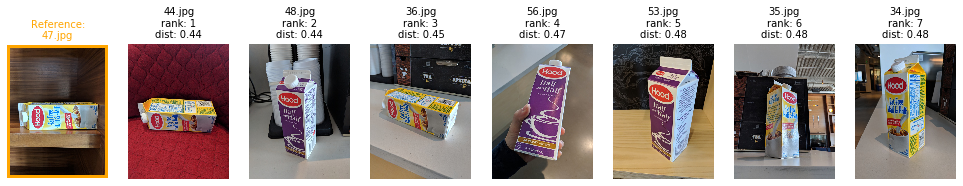

In [11]:
# Query the nearest neighbor object to find all reference images which are similar to the query image
query_feature = np.reshape(query_feature, (-1, 512))
approx_distances, approx_im_indices = nn.kneighbors(query_feature)

# Display the results
approx_im_paths = [str(data.valid_ds.items[i]) for i in approx_im_indices[0]]
plot_distances(list(zip(approx_im_paths, approx_distances[0])), 
               num_rows=1, num_cols=8, figsize=(17,5))

## Retrieval speed

This section compares retrieval times of exhaustive-search versus approximate nearest neighbor search by running the respective algorithms multiple times.  To avoid effects from cashing, a new query image is selected for each run at random.

Exhaustive search is fast for the small dataset used in this notebook. However, when using even a modest sized dataset with 5,000 (100,000) images, exhaustive-search already takes 0.1 (2.1) seconds per query image. In comparison, approximate-search takes 5 (95) miliseconds, ie. is 20 times faster. 

More speed-gains (however possibly at the loss of retrieval accuracy) can be gained by selecting different parameters for the *NearestNeighbors* object - for more info on this see the scikit-learn site on [Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html).

In [12]:
# Compute features for the training set, from which query images will be randomly selected
train_features = compute_features_learner(data, DatasetType.Train, learn, embedding_layer)
print(f"Computed DNN features for the {len(list(train_features))} training images,\
each consisting of {len(train_features[list(train_features)[0]])} floating point values.")

Computed DNN features for the 27 training images,each consisting of 512 floating point values.


In [13]:
%%timeit
query_im_path = str(np.random.choice(data.train_ds.items))
query_feature = train_features[query_im_path]
distances = compute_distances(query_feature, valid_features)

2.14 ms ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit
query_im_path = str(np.random.choice(data.train_ds.items))
query_feature = train_features[query_im_path]
query_feature /= np.linalg.norm(query_feature, 2)
query_feature = np.reshape(query_feature, (-1, 512))
approx_distances, approx_im_indices = nn.kneighbors(query_feature)

492 µs ± 4.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Retrieval accuracy

Nearest neighbor methods are much faster than brute-force search, however these methods can sometimes be incorrect, ie. return what is deemed to be the most similar image even though there are images with lower L2 distance in the dataset.

To measure retrieval accuracy we use brute-force search to find the *true* image with lowest L2 distance, and then compare at what position this image is placed using our nearest neighbor object. Ideally, we would like 

In [15]:
from tqdm import tqdm

ranks = []
for iter in tqdm(range(100)):
    
    # Get random query image
    query_im_path = str(np.random.choice(data.train_ds.items))
    query_feature = train_features[query_im_path]
    assert len(query_feature) == 512

    # Find closest match (ie. most similar image) using brute-force search 
    bf_distances_and_paths = compute_distances(query_feature, valid_features)
    bf_distances = [d for (p,d) in bf_distances_and_paths]
    bf_closest_match_path = bf_distances_and_paths[np.argmin(bf_distances)][0]

    # Find closest match (ie. most similar image) using nearest-neighbor search
    query_feature /= np.linalg.norm(query_feature, 2)
    query_feature = np.reshape(query_feature, (-1, 512))
    approx_distances, approx_im_indices = nn.kneighbors(query_feature)

    # Find at what position (ie rank) the brute-force result is within the nearest-neighbor search result
    # Best: rank 1. 
    approx_im_paths = [str(data.valid_ds.items[i]) for i in approx_im_indices[0]]
    rank = np.where(np.array(approx_im_paths) == bf_closest_match_path)[0]
    assert len(rank) == 1
    ranks.append(float(rank)+1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 338.99it/s]


Analyse result. Best would be if the approximate nearest neighbor is as good as the brute-force search, ie if the rank is always 1.

In [16]:
print(f"The median rank over {len(ranks)} runs with {len(valid_features)} reference images is {np.median(ranks)}, and average rank is {np.mean(ranks)}.")

The median rank over 100 runs with 107 reference images is 1.0, and average rank is 1.0.


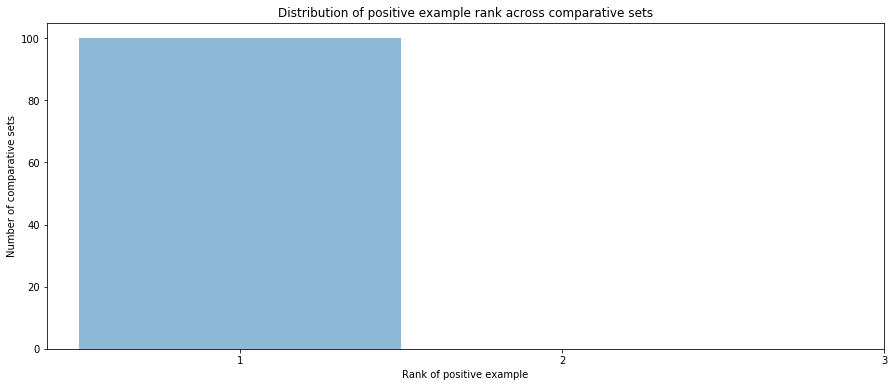

In [17]:
# Display the distribution of ranks
plot_ranks_distribution(ranks)

In [18]:
# Log some outputs using scrapbook which are used during testing to verify correct notebook execution
sb.glue("feature_dimension", len(query_feature[0]))
sb.glue("median_rank", np.median(ranks))